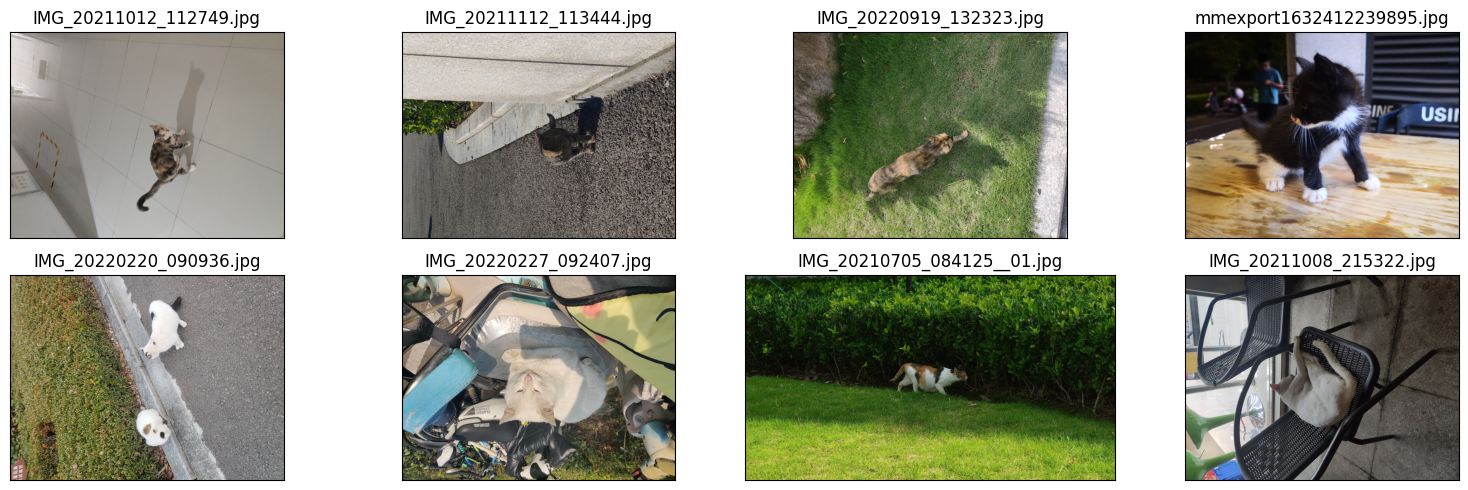

In [2]:
import os

import matplotlib.pyplot as plt
from PIL import Image

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

image_paths = [filename for filename in os.listdir('../data/cat/cat_dataset/images')][:8]

for i, filename in enumerate(image_paths):
    name = os.path.splitext(filename)[0]

    image = Image.open('../data/cat/cat_dataset/images/' + filename).convert('RGB')

    plt.subplot(2, 4, i + 1)
    plt.imshow(image)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


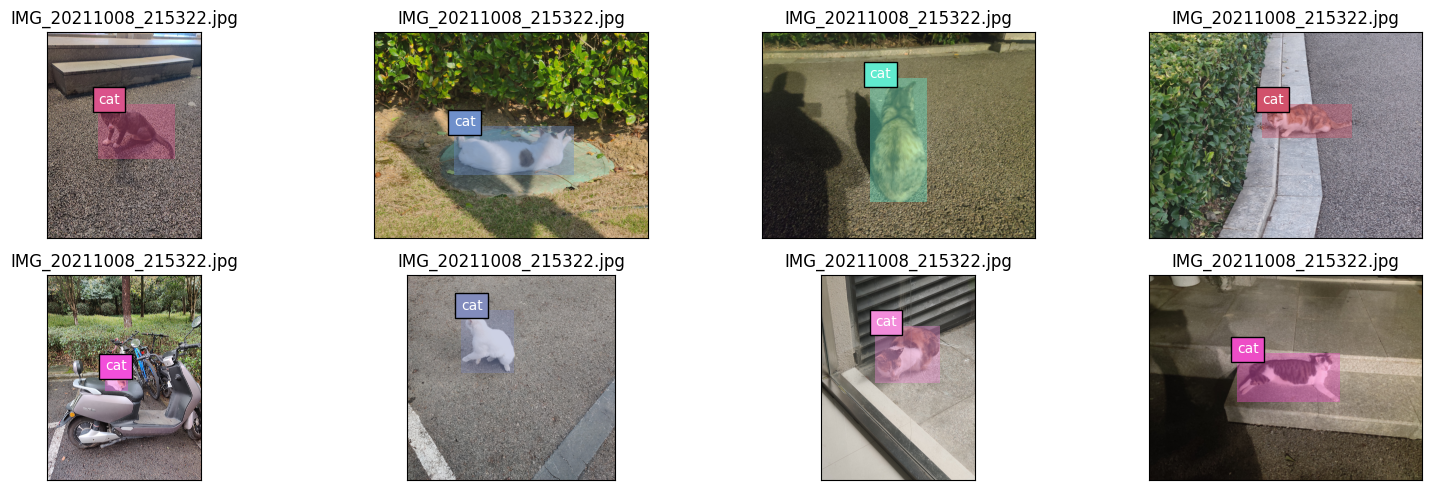

In [4]:
from pycocotools.coco import COCO
import numpy as np
import os.path as osp
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon


def apply_exif_orientation(image):
    _EXIF_ORIENT = 274
    if not hasattr(image, 'getexif'):
        return image

    try:
        exif = image.getexif()
    except Exception:
        exif = None

    if exif is None:
        return image

    orientation = exif.get(_EXIF_ORIENT)

    method = {
        2: Image.FLIP_LEFT_RIGHT,
        3: Image.ROTATE_180,
        4: Image.FLIP_TOP_BOTTOM,
        5: Image.TRANSPOSE,
        6: Image.ROTATE_270,
        7: Image.TRANSVERSE,
        8: Image.ROTATE_90
    }.get(orientation)

    if method is not None:
        image = image.transpose(method)

    return image


def show_bbox_only(coco, anns, show_label_bbox=True, is_filling=True):
    if len(anns) == 0:
        return

    ax = plt.gca()
    ax.set_autoscale_on(False)

    image2color = dict()
    for cat in coco.getCatIds():
        image2color[cat] = (np.random.random((1, 3)) * 0.7 + 0.3).tolist()[0]
    
    polygons = []
    colors = []
    
    for ann in anns:
        color = image2color[ann['category_id']]
        bbox_x, bbox_y, bbox_w, bbox_h = ann['bbox']
        poly = [[bbox_x,bbox_y],[bbox_x,bbox_y+bbox_h],[bbox_x+bbox_w,bbox_y+bbox_h],[bbox_x+bbox_w,bbox_y]]
        
        polygons.append(Polygon(np.array(poly).reshape((4, 2))))
        colors.append(color)
        
        if show_label_bbox:
            label_bbox = dict(facecolor=color)
        else:
            label_bbox = None
            
        ax.text(
            bbox_x,
            bbox_y,
            "%s" % coco.loadCats(ann['category_id'])[0]['name'],
            bbox=label_bbox,
            color='white'
        )
        
    if is_filling:
        p = PatchCollection(
            polygons,facecolors=colors,linewidths=0,alpha=0.4
        )
        ax.add_collection(p)

coco = COCO('../data/cat/cat_dataset/annotations/test.json')
image_ids = coco.getImgIds()
np.random.shuffle(image_ids)

plt.figure(figsize=(16, 5))

for i in range(8):
    image_data = coco.loadImgs(image_ids[i])[0]
    image_path = osp.join('../data/cat/cat_dataset/images', image_data['file_name'])
    
    annotation_ids = coco.getAnnIds(imgIds=image_data['id'],catIds=[],iscrowd=0)
    annotations = coco.loadAnns(annotation_ids)
    
    ax = plt.subplot(2, 4, i + 1)
    image = Image.open(image_path).convert('RGB')
    
    image = apply_exif_orientation(image)
    
    ax.imshow(image)
    
    show_bbox_only(coco, annotations)
    plt.title(f"{filename}")
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()